# Inference of Gene Regulatory Network using Kinetic Ising Model


In [1]:
from datetime import date

print("Last run date:", date.today())

Last run date: 2023-03-15


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

import sys
sys.path.append('../')

import lib.NetAnalysis as na
import lib.fun_plotting as fun_plotting
import lib.funcs_general as funcs_general
import lib.funcs_IsingPars as funcs_Ising

%load_ext autoreload
%autoreload 2

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

# Initial information

In [3]:
path      = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/" 
path_data = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/DATA/"

In [4]:
# genes of OUR dataset
genes_order = np.loadtxt(path_data+"general_info/genes_order.csv", dtype="str") #selected genes

# time steps
time=["00h", "06h", "12h", "24h", "48h"]

# Genes Classification
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative = ["Nr0b1", "Zic3", "Rbpj", "Utf1", "Etv4", "Tcf15"]
committed = ["Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]



## Pseudotime

In [5]:
# load the Gene Expression data log normalized: the columns are the cells and the rows are the genes
df_lN_pst= pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST.csv", header=0, index_col=0, sep=",")


# load the Gene Expression data Psi Normalized: the columns are the cells and the rows are the genes
df_pN_pst= pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST.csv", header=0, index_col=0, sep=",")

df_pN_pst.head(3)

,TTCAGGAAGCAGTACG,GTAGATCAGTAGGTTA,CGAAGGACACGGGCTT,GTCGCGAGTCGTCTCT,CCTTCAGGTCCAGCGT,CTCCGATAGCATCCTA,CAACGATAGATGAACT,GTGTCCTAGAATTGCA,TGCGACGTCGTGTCAA,CTCAATTAGGCTAAAT,...,AACAAAGAGAGCGACT,TCATACTAGGTGTGAC,GCCATTCAGCCAGAGT,AACAGGGGTGCACGCT,GATCATGTCTGTAACG,GATTCGAAGATACAGT,GCCAGGTAGAAGAACG,CGTGCTTTCGACGTCG,AGGGTGACAATACGAA,CCACAAAAGCGTGAAC
Klf4,0.000000,0.0,0.000000,0.0,2.534856,2.337277,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,1.502543,0.0,0.000000,0.0,0.0,0.0,0.0
Klf2,1.705748,0.0,3.095388,0.0,1.377622,1.233372,0.0,0.0,2.131445,0.000000,...,1.308057,0.0,0.0,1.502543,0.0,1.389484,0.0,0.0,0.0,0.0
Esrrb,0.000000,0.0,0.000000,0.0,0.000000,1.233372,0.0,0.0,2.131445,1.116785,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


# Binarization (Half-max)

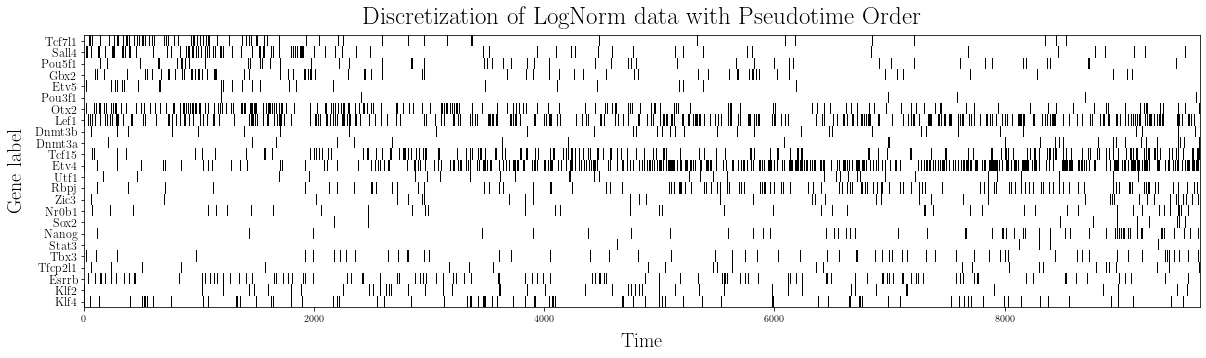

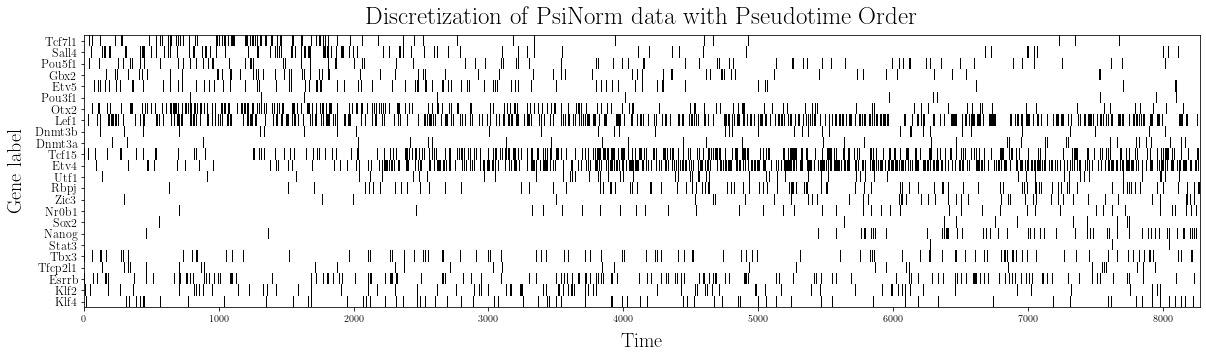

In [6]:
spins_df_lN_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST_Spins.csv", header=0, index_col=0, sep=",")

fun_plotting.raster_plot(np.array(spins_df_lN_pst), 'Discretization of LogNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()


spins_df_pN_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_Spins.csv", header=0, index_col=0, sep=",")

fun_plotting.raster_plot(np.array(spins_df_pN_pst), 'Discretization of PsiNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()



# Randomization

In [7]:
spins_df_lN_pst_shuffle = np.load(path_data + "GE_data/processed/imp_genes_LogNorm_PST_Spins_RND50Test.npy")
spins_df_pN_pst_shuffle = np.load(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_Spins_RND50Test.npy")
 
Ntest = spins_df_lN_pst_shuffle.shape[0] 


In [8]:
print("N_test = ", Ntest)

N_test =  50


In [9]:
check=True
if check:
    # Check the reshuffle
    print(funcs_general.check_shuffle(spins_df_lN_pst_shuffle, Ntest))
    print(funcs_general.check_shuffle(spins_df_pN_pst_shuffle, Ntest))
    
    # zero expected if everithing is working fine

0.0
0.0


In [10]:
show = False
if show:
    for ii in range(0, Ntest, 60):
            fun_plotting.raster_plot(np.array(spins_df_lN_pst_shuffle[ii,:,:]), 'Discretization of LogNorm data with PST - RND '+str(ii+1), 1, genes_order[::-1])
            plt.show()    
            fun_plotting.raster_plot(np.array(spins_df_pN_pst_shuffle[ii,:,:]), 'Discretization of PsiNorm data with PST - RND '+str(ii+1), 1, genes_order[::-1])
            plt.show() 
            

# Known Experimentally

## Neighbours interactions

In [11]:
TPtrial_list = ["Stat3 Klf4 1", "Nanog Esrrb 1", "Stat3 Dnmt3b -1", 
                "Nanog Otx2 -1", "Nanog Pou3f1 -1",
                "Stat3 Gbx2 1", "Stat3 Tfcp2l1 1", 
                "Otx2 Pou3f1 1", "Otx2 Dnmt3a 1", 
                "Tcf7l1 Esrrb -1", "Tcf7l1 Klf2 -1", "Tcf7l1 Nanog -1", "Tcf7l1 Nr0b1 -1",  "Tcf7l1 Tfcp2l1 -1",  
                "Rbpj Nanog -1", "Rbpj Tbx3 -1", "Etv5 Lef1 1", "Etv5 Pou3f1 1"]


## Directed Correlations

In [12]:
df_KO_N24_Leeb_cl = pd.read_csv(path_data+'Leeb_Data_Orig/df_KO_N24_cleaned.csv', index_col=0, header=0)

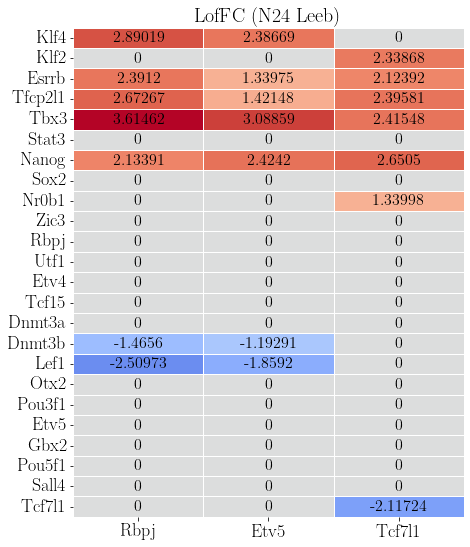

In [13]:
correlations_list = funcs_general.InteractionList(df_KO_N24_Leeb_cl, perc = 0)

fun_plotting.plot_log2FC(df_KO_N24_Leeb_cl, "LofFC (N24 Leeb)")

# Grid search for _hyperparameters_

In [14]:
params = {"LAMBDA" : [0.01, 0.02, 0.03,0.04, 0.05, 0.07, 0.09],
          "lr"     : [0.8, 0.7, 0.6, 0.5, 0.4, 0.3],
          "drop"   : [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99],
          "edrop"  : [15, 20, 25, 30, 35],
          "opt"    : ['MOMENTUM','NADAM'],
          "MOM"    : [0.75, 0.8, 0.85, 0.9, 0.95, 0.99],
          "reg"    : ['L1'],
          "Nepochs": [500, 700, 800, 900, 1200]}


# Implementation for the Real Data

Threshold = 1% of the maximum

In [20]:
interaction_thr = 0.01
Ntrials = 150
compute = False

today = "23_03_15" #or other data
data_type = "pst"

if compute:
    lN_matx_sel_true, lN_prec_sel_true, lN_int_val_true = funcs_Ising.grid_search(np.array(spins_df_lN_pst), params, TPtrial_list, 
                                                             genes_order, Ntrials = Ntrials, seedSet=20961, 
                                                                      Norm=True, thr=interaction_thr)
    pN_matx_sel_true, pN_prec_sel_true, pN_int_val_true = funcs_Ising.grid_search(np.array(spins_df_pN_pst), 
                                                                      params, TPtrial_list, 
                                                                      genes_order, Ntrials = Ntrials, seedSet=20961, 
                                                                      Norm=True, thr=interaction_thr)
else: 
    # LOADING the data    
    lN_arrays = np.load(path_data+'OUT_ISING/LogNORM/lN_arrays_'+data_type+'_'+str(today)+'.npz')#+'_thr'+str(interaction_thr*100)+'.npz')
    lN_matx_sel_true = lN_arrays['array_1']
    lN_prec_sel_true = lN_arrays['array_2']
    lN_int_val_true = lN_arrays['array_3']
    
    pN_arrays = np.load(path_data+'OUT_ISING/PsiNORM/pN_arrays_'+data_type+'_'+str(today)+'.npz')#+'_thr'+str(interaction_thr*100)+'.npz')
    pN_matx_sel_true = pN_arrays['array_1'][:200,:,:]
    pN_prec_sel_true = pN_arrays['array_2'][:200]
    pN_int_val_true =  pN_arrays['array_3'][:,:,:200]


In [ ]:

saving = False
if saving:
    np.savez(path_data + 'OUT_ISING/LogNORM/lN_arrays_pst_23_03_15.npz', array_1=lN_matx_sel_true, array_2=lN_prec_sel_true, array_3=lN_int_val_true)
    np.savez(path_data + 'OUT_ISING/PsiNORM/pN_arrays_pst_23_03_15.npz', array_1=pN_matx_sel_true, array_2=pN_prec_sel_true, array_3=pN_int_val_true)


In [21]:
lN_TP_max = lN_prec_sel_true.max()
pN_TP_max = pN_prec_sel_true.max()
print("LogNorm PST max: ", lN_TP_max)
print("PsiNorm PST max: ", pN_TP_max)


LogNorm PST max:  0.7777777777777778
PsiNorm PST max:  0.6666666666666666


## LogNorm 

Index of the model that satisfied the condition, [  0   3   6   7   8  12  14  16  18  19  20  21  28  29  32  33  35  37
  38  39  42  46  47  50  52  60  61  66  69  71  87  89  90  92  97  98
 106 108 109 112 113 114 117 122 125 129 132 133 134 137 139 140 143 144
 149]
N Used Matrices 55


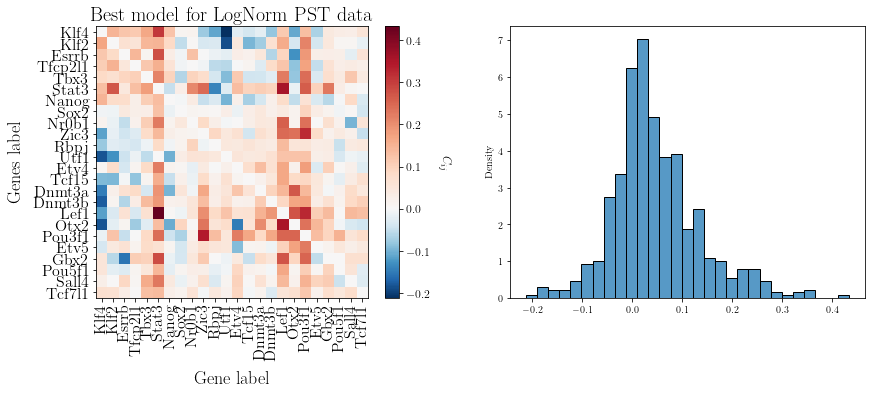

Threshold value : 0.004
Fraction of True Positives 0.78
Discarded Interactions : 3.299%


In [31]:
lN_high_meanMatx, lN_model_idxs = funcs_general.Inferred_matrix(lN_prec_sel_true, lN_matx_sel_true, TPtrial_list, genes_order, interaction_thr, "LogNorm PST")
# infos about the best model
print("Index of the model that satisfied the condition," ,lN_model_idxs)
print("N Used Matrices", len(lN_model_idxs))

lN_Mean_TP_frac, lN_Mean_info_int, _ = funcs_general.TP_plot(TPtrial_list, lN_high_meanMatx, genes_order, 
                                                   inferred_int_thr=interaction_thr, Norm_Matx = False,
                                                   data_type=" Best model for LogNorm PST  data",
                                                   figplot=True, verbose=False, nbin=30, Norm = True)
lN_thr_val = np.max(np.abs(lN_high_meanMatx))*interaction_thr
print(f"Threshold value : {'{:.3f}'.format(lN_thr_val)}")
print("Fraction of True Positives", np.round(lN_Mean_TP_frac,2))

# print("Not Normalized interactions", np.round(lN_Mean_info_int[2,:],2))
# print("Not Normalized TRUE interactions\n", np.round(lN_Mean_info_int[2,:]*lN_Mean_info_int[3,:],3))
# print("Normalized TRUE interactions", np.round(lN_Mean_info_int[2,:]*lN_Mean_info_int[3,:]/np.max(np.abs(lN_high_meanMatx)), 2))
# print("Normalized interactions", np.round(lN_Mean_info_int[2,:]/np.max(np.abs(lN_high_meanMatx)), 2))


lN_high_meanMatx_thr = na.to_thr_matrix(lN_high_meanMatx, thr=interaction_thr)
lN_discarded_ints = (len(np.where(lN_high_meanMatx_thr==0)[0])-len(np.where(lN_high_meanMatx==0)[0]))/((len(genes_order))**2)
print(f"Discarded Interactions : {'{:.3f}'.format(lN_discarded_ints*100)}%")

# to save
# np.save(path_data + "OUT_ISING/LogNORM/LogNorm_InferredMatrix_onlyPST.npy", lN_high_meanMatx)
# np.save(path_data + "OUT_ISING/LogNORM/LogNorm_TPfrac_onlyPST.npy", lN_Mean_TP_frac)
# np.save(path_data + "OUT_ISING/LogNORM/LogNorm_info_ints_onlyPST.npy", lN_Mean_info_int)


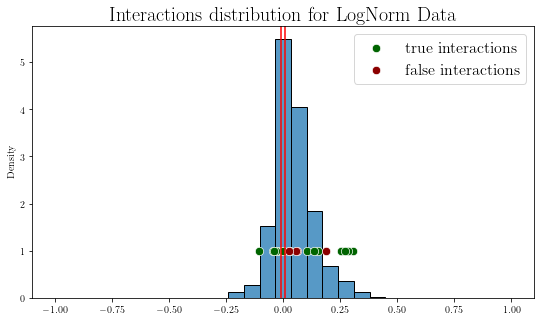

In [25]:
nbin=30
bins = np.linspace(-1, 1, nbin)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
sns.scatterplot(x= lN_Mean_info_int[2,:]*lN_Mean_info_int[3,:],y=np.ones_like(1), ax=ax,  color="darkgreen", lw=3, label="true interactions", zorder=1, s=70)
sns.scatterplot(x= lN_Mean_info_int[2,lN_Mean_info_int[3,:]==0],y=np.ones_like(1), ax=ax,  color="darkred", lw=3, label="false interactions", zorder=1, s=70)

sns.histplot(np.ndarray.flatten(lN_high_meanMatx), ax=ax, stat="density", bins=bins, zorder=0)
ax.axvline(interaction_thr, color='red', linestyle='-')
ax.axvline(-interaction_thr, color='red', linestyle='-')
plt.legend(markerscale=1, fontsize=16)
plt.title("Interactions distribution for LogNorm Data", fontsize=20)
plt.show()

Directed Correlations

In [27]:
lN_Mean_TP_frac_2, lN_Mean_info_int_2, _ = funcs_general.TP_plot(correlations_list, lN_high_meanMatx, genes_order, 
                                                   inferred_int_thr=interaction_thr, Norm_Matx = False,
                                                   data_type=" Best model for LogNorm PST data",
                                                   figplot=False, verbose=False, nbin=30, Norm = True)
print(f"{lN_Mean_TP_frac_2:.2f}")


0.24


## PsiNorm

Index of the model that satisfied the condition, [  0   3   6   7   8  16  18  20  29  32  33  35  36  38  39  46  47  49
  50  52  55  60  61  63  65  66  69  75  79  81  87  88  89  90  92  97
 100 106 108 109 110 112 113 114 117 118 119 122 123 125 130 132 133 136
 137 138 139 140 144 148 149]
N Used Matrices 61

RESULTS for  Best model for PsiNorm PST  data

TP fraction: 0.67

Interaction values:
 [ 0.138  0.035  0.277 -0.196 -0.182  0.221  0.343  0.398  0.177  0.049
  0.087  0.062  0.025  0.011 -0.022 -0.026  0.238  0.317]

TP ints values:
 [ 0.138  0.035  0.    -0.196 -0.182  0.221  0.343  0.398  0.177  0.
  0.     0.     0.     0.    -0.022 -0.026  0.238  0.317]


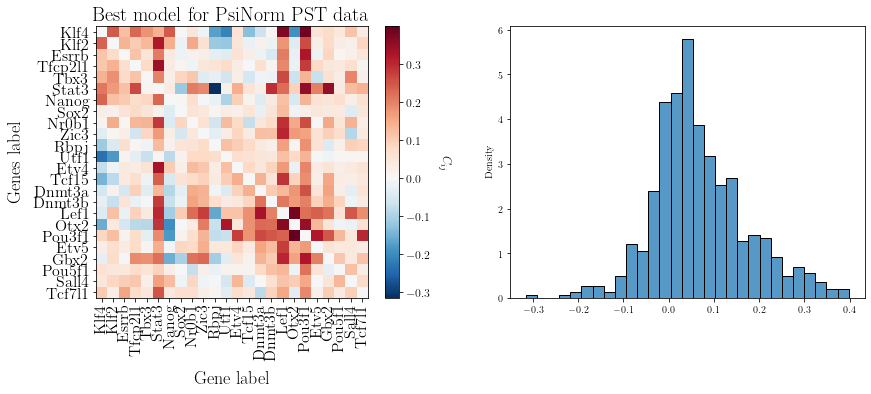

Threshold value : 0.004
Fraction of True Positives 0.67
Discarded Interactions : 1.910%


In [32]:
pN_high_meanMatx, pN_model_idxs = funcs_general.Inferred_matrix(pN_prec_sel_true, pN_matx_sel_true, TPtrial_list, genes_order, interaction_thr, "PsiNorm PST")
# infos about the best model
print("Index of the model that satisfied the condition," ,pN_model_idxs)
print("N Used Matrices", len(pN_model_idxs))

# evaluate the best model
pN_Mean_TP_frac, pN_Mean_info_int, _ = funcs_general.TP_plot(TPtrial_list, pN_high_meanMatx, genes_order, 
                                                   inferred_int_thr=interaction_thr, Norm_Matx = False,
                                                   data_type=" Best model for PsiNorm PST  data",
                                                   figplot=True, verbose=True, nbin=30, Norm = True)
pN_thr_val = np.max(np.abs(pN_high_meanMatx))*interaction_thr
print(f"Threshold value : {'{:.3f}'.format(pN_thr_val)}")
print("Fraction of True Positives", np.round(pN_Mean_TP_frac,2))

# print("Not Normalized interactions", np.round(pN_Mean_info_int[2,:],2))
# print("Not Normalized TRUE interactions\n", np.round(pN_Mean_info_int[2,:]*pN_Mean_info_int[3,:],3))
# print("Normalized TRUE interactions", np.round(pN_Mean_info_int[2,:]*pN_Mean_info_int[3,:]/np.max(np.abs(pN_high_meanMatx)), 2))
# print("Normalized interactions", np.round(pN_Mean_info_int[2,:]/np.max(np.abs(pN_high_meanMatx)), 2))

pN_high_meanMatx_thr = na.to_thr_matrix(pN_high_meanMatx, thr=interaction_thr)
pN_discarded_ints = (len(np.where(pN_high_meanMatx_thr==0)[0])-len(np.where(pN_high_meanMatx==0)[0]))/((len(genes_order))**2)
print(f"Discarded Interactions : {'{:.3f}'.format(pN_discarded_ints*100)}%")


# to save
# np.save(path_data + "OUT_ISING/PsiNORM/PsiNorm_InferredMatrix_onlyPST.npy", pN_high_meanMatx)
# np.save(path_data + "OUT_ISING/PsiNORM/PsiNorm_TPfrac_onlyPST.npy", pN_Mean_TP_frac)
# np.save(path_data + "OUT_ISING/PsiNORM/PsiNorm_info_ints_onlyPST.npy", pN_Mean_info_int)

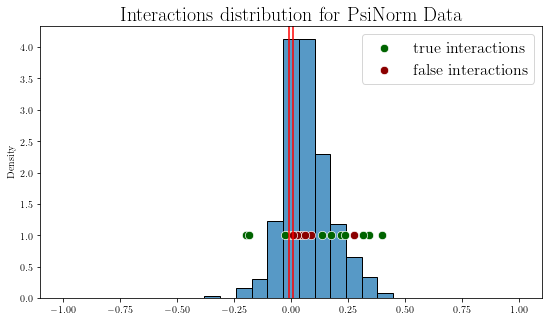

In [29]:
nbin=30
bins = np.linspace(-1, 1, nbin)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
sns.scatterplot(x= pN_Mean_info_int[2,:]*pN_Mean_info_int[3,:],y=np.ones_like(1), ax=ax,  color="darkgreen", lw=3, label="true interactions", zorder=1, s=70)
sns.scatterplot(x= pN_Mean_info_int[2,pN_Mean_info_int[3,:]==0],y=np.ones_like(1), ax=ax,  color="darkred", lw=3, label="false interactions", zorder=1, s=70)

sns.histplot(np.ndarray.flatten(pN_high_meanMatx), ax=ax, stat="density", bins=bins, zorder=0)
ax.axvline(interaction_thr, color='red', linestyle='-')
ax.axvline(-interaction_thr, color='red', linestyle='-')
plt.legend(markerscale=1, fontsize=16)
plt.title("Interactions distribution for PsiNorm Data", fontsize=20)
plt.show()

Directed Correlations

In [30]:
pN_Mean_TP_frac_2, pN_Mean_info_int_2, _ = funcs_general.TP_plot(correlations_list, pN_high_meanMatx, genes_order, 
                                                   inferred_int_thr=interaction_thr, Norm_Matx = False,
                                                   data_type=" Best model for LogNorm PST  data",
                                                   figplot=False, verbose=False, nbin=30, Norm = True)
print(f"{pN_Mean_TP_frac_2:.2f}")


0.52


# Implementation for reshuffled data

In [ ]:
Ntrials = 50  # on the parameters
Ntest   = 50  # on the datasets
compute = False

if compute:
    pN_matx_sel_rnd = np.zeros((Ntest, Ntrials, len(genes_order), len(genes_order)))
    lN_matx_sel_rnd = np.zeros((Ntest, Ntrials, len(genes_order), len(genes_order)))

    pN_prec_sel_rnd = np.zeros((Ntest, Ntrials))
    lN_prec_sel_rnd = np.zeros((Ntest, Ntrials))

    pN_int_val_rnd  = np.zeros((4, len(TPtrial_list), Ntrials, Ntest))
    lN_int_val_rnd  = np.zeros((4, len(TPtrial_list), Ntrials, Ntest))

    for ii in range(Ntest):
        print("\n Testing Sample "+str(ii+1))
        pN_matx_sel_rnd[ii,:,:,:], pN_prec_sel_rnd[ii, :], pN_int_val_rnd[:, :, :, ii] = funcs_Ising.grid_search(np.array(spins_df_pN_pst_shuffle[ii,:,:]), 
                                                                                                        params, TPtrial_list, 
                                                                                                        genes_order, seedSet=ii*2, 
                                                                                                        Ntrials = Ntrials,
                                                                                                        Norm=True, thr=0)
        
        lN_matx_sel_rnd[ii,:,:,:],  lN_prec_sel_rnd[ii, :],  lN_int_val_rnd[:, :, :, ii]  = funcs_Ising.grid_search(np.array(spins_df_lN_pst_shuffle[ii,:,:]), 
                                                                                                        params, TPtrial_list, 
                                                                                                        genes_order, seedSet=ii*2, 
                                                                                                        Ntrials = Ntrials,
                                                                                                        Norm=True, thr=0)
else:
    # LOADING the data
    pN_arrays_rnd = np.load(path_data+'OUT_ISING/PsiNORM/pN_arrays_pst_RND_23_1_23.npz')
    pN_matx_sel_rnd = pN_arrays_rnd['array_1']
    pN_prec_sel_rnd = pN_arrays_rnd['array_2']
    pN_int_val_rnd =  pN_arrays_rnd['array_3']
    
    lN_arrays_rnd = np.load(path_data+'OUT_ISING/LogNORM/lN_arrays_pst_RND_23_1_23.npz')
    lN_matx_sel_rnd = lN_arrays_rnd['array_1']
    lN_prec_sel_rnd = lN_arrays_rnd['array_2']
    lN_int_val_rnd = lN_arrays_rnd['array_3']

## Result

### Interaction distribution

In [ ]:
# LogNorm
lN_ints_rnd_all = lN_matx_sel_rnd.flatten()

plt.figure(figsize=(9,6))
bins = np.linspace(-0.1,0.1,50)
sns.histplot(lN_ints_rnd_all, bins=bins, stat="density")

plt.xlabel(xlabel='Interaction value', fontsize=14)
plt.axvline(x = np.quantile(lN_ints_rnd_all,[0.05, 0.5, 0.95])[0], color = 'red', label = 'axvline - full height')
plt.axvline(x = np.quantile(lN_ints_rnd_all,[0.05, 0.5, 0.95])[1], color = 'red', label = 'axvline - full height')
plt.axvline(x = np.quantile(lN_ints_rnd_all,[0.05, 0.5, 0.95])[2], color = 'red', label = 'axvline - full height')

print("quantiles", np.round(np.quantile(lN_ints_rnd_all,[0.05, 0.5, 0.95]),3))

# PsiNorm
pN_ints_rnd_all = pN_matx_sel_rnd.flatten()

plt.figure(figsize=(9,6))
bins = np.linspace(-0.1,0.1,50)
sns.histplot(pN_ints_rnd_all, bins=bins, stat="density")

plt.xlabel(xlabel='Interaction value', fontsize=14)
plt.axvline(x = np.quantile(pN_ints_rnd_all,[0.05, 0.5, 0.95])[0], color = 'red', label = 'axvline - full height')
plt.axvline(x = np.quantile(pN_ints_rnd_all,[0.05, 0.5, 0.95])[1], color = 'red', label = 'axvline - full height')
plt.axvline(x = np.quantile(pN_ints_rnd_all,[0.05, 0.5, 0.95])[2], color = 'red', label = 'axvline - full height')

print("quantiles", np.round(np.quantile(pN_ints_rnd_all,[0.05, 0.5, 0.95]),2))


### Setting the TP threshold based on data

#### Random data

In [ ]:
# print(raw_matx_sel_rnd.shape, raw_prec_sel_rnd.shape, raw_int_val_rnd.shape )
pN_int_val_rnd_all = pN_int_val_rnd.reshape((4,18,50*50))
print("Nuer of test*trial TP frac:", pN_int_val_rnd_all.shape)

pN_TPfrac_thr = np.zeros(pN_int_val_rnd_all.shape[2])
for kk in range(pN_int_val_rnd_all.shape[2]):
    pN_TPfrac_thr[kk]= len(np.where(np.abs(pN_int_val_rnd_all[2,:,kk]*pN_int_val_rnd_all[3,:,kk])>interaction_thr)[0])/len(pN_int_val_rnd_all[2,:,kk])
    
# quartiles of ALL the random interactions
print(np.quantile(pN_TPfrac_thr,[0.05, 0.5, 0.95]))

sns.set(style="darkgrid")
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
# creating the figure containing the distribution and the box plot
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(9, 6))
 
# assigning a graph to each ax
sns.boxplot(pN_TPfrac_thr, ax=ax_box)
sns.histplot(pN_TPfrac_thr, ax=ax_hist, stat="density", bins=19, binrange = (0,1))
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_hist.set(xlabel='fraction of correct interactions')
pN_TP_true_thr = len(np.where(np.abs(pN_Mean_info_int[2,:]*pN_Mean_info_int[3,:])>interaction_thr)[0])/18
plt.axvline(x = pN_TP_true_thr, color = 'red', label = 'axvline - full height')
plt.title("Raw data")
plt.show()

sns.set_style("white")   

print("TP fraction for Raw data: ", pN_TP_true_thr)

    

In [ ]:
# print(lN_matx_sel_rnd.shape, lN_prec_sel_rnd.shape, lN_int_val_rnd.shape )
lN_int_val_rnd_all = lN_int_val_rnd.reshape((4,18,50*50))
print("Nu er of test*trial TP frac:", lN_int_val_rnd_all.shape)

lN_TPfrac_thr = np.zeros(lN_int_val_rnd_all.shape[2])
for kk in range(lN_int_val_rnd_all.shape[2]):
    lN_TPfrac_thr[kk]= len(np.where(np.abs(lN_int_val_rnd_all[2,:,kk]*lN_int_val_rnd_all[3,:,kk])>interaction_thr)[0])/len(lN_int_val_rnd_all[2,:,kk])
    
# quartiles of ALL the random interactions
print(np.quantile(lN_TPfrac_thr,[0.05, 0.5, 0.95]))


# plot setting
sns.set(style="darkgrid")
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(9, 6))
# plot
sns.boxplot(lN_TPfrac_thr, ax=ax_box)
sns.histplot(lN_TPfrac_thr, ax=ax_hist, stat="density", bins=19, binrange = (0,1))
# other plot stuff
ax_box.set(xlabel='')
ax_hist.set(xlabel='fraction of correct interactions')

lN_TP_true_thr = len(np.where(np.abs(lN_Mean_info_int[2,:]*lN_Mean_info_int[3,:])>interaction_thr)[0])/18
plt.axvline(x = lN_TP_true_thr, color = 'red', label = 'axvline - full height')
plt.title("LogNorm data")
plt.show()

# reset of the plot style
sns.set_style("white")    

print("TP fraction for LogNorm data: ", lN_TP_true_thr)
    

#### True data

In [ ]:
pN_TPfrac_thr_true = np.zeros(pN_int_val_true.shape[2])
pN_idx_TPhigh_true = []
for kk in range(pN_int_val_true.shape[2]):
    pN_TPfrac_thr_true[kk]= len(np.where(np.abs(pN_int_val_true[2,:,kk]*pN_int_val_true[3,:,kk])>interaction_thr)[0])/len(pN_int_val_true[2,:,kk])
    if pN_TPfrac_thr_true[kk]>=0.65:
        print("Index of the model that satisfied the condition, ", kk)
        pN_idx_TPhigh_true.append(kk)
        
    
# quartiles of ALL the random interactions
print(np.quantile(pN_TPfrac_thr_true,[0.05, 0.5, 0.95]))

sns.set(style="darkgrid")
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
# creating the figure containing the distribution and the box plot
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(9, 6))
 
# assigning a graph to each ax
sns.boxplot(pN_TPfrac_thr_true, ax=ax_box)
sns.histplot(pN_TPfrac_thr_true, ax=ax_hist, stat="density", bins=19, binrange = (0,1))
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_hist.set(xlabel='fraction of correct interactions')
pN_TP_true_thr = len(np.where(np.abs(pN_Mean_info_int[2,:]*pN_Mean_info_int[3,:])>interaction_thr)[0])/18
plt.axvline(x = pN_TP_true_thr, color = 'red', label = 'axvline - full height')
plt.title("PsiNorm data")
plt.show()

sns.set_style("white")   

print(f"TP fraction for PsiNorm data: {pN_TP_true_thr:.2f}")

    

In [ ]:
lN_TPfrac_thr_true = np.zeros(lN_int_val_true.shape[2])
lN_idx_TPhigh_true = []
for kk in range(lN_int_val_true.shape[2]):
    lN_TPfrac_thr_true[kk]= len(np.where(np.abs(lN_int_val_true[2,:,kk]*lN_int_val_true[3,:,kk])>interaction_thr)[0])/len(lN_int_val_true[2,:,kk])
    if lN_TPfrac_thr_true[kk]>=0.6:
        lN_idx_TPhigh_true.append(kk)
        
    
# quartiles of ALL the random interactions
print(np.quantile(lN_TPfrac_thr_true,[0.05, 0.5, 0.95]))

sns.set(style="darkgrid")
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
# creating the figure containing the distribution and the box plot
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(9, 6))
 
# assigning a graph to each ax
sns.boxplot(lN_TPfrac_thr_true, ax=ax_box)
sns.histplot(lN_TPfrac_thr_true, ax=ax_hist, stat="density", bins=19, binrange = (0,1))
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_hist.set(xlabel='fraction of correct interactions')
lN_TP_true_thr = len(np.where(np.abs(lN_Mean_info_int[2,:]*lN_Mean_info_int[3,:])>interaction_thr)[0])/18
plt.axvline(x = lN_TP_true_thr, color = 'red', label = 'axvline - full height')
plt.title("LogNorm data")
plt.show()

sns.set_style("white")   

# print("TP fraction for lN data: ", lN_TP_true_thr)
print(f"TP fraction for LogNorm data: {lN_TP_true_thr:.2f}")


### Distibutions of known interactions

In [ ]:
def TP_distribution(interaction_list, interaction_matrices, genes_list):

    int_val = np.zeros((len(interaction_list), interaction_matrices.shape[0]))
    for ii in range(len(interaction_list)):
        couple = interaction_list[ii].split(" ")
        gene1_idx = np.where(genes_list == couple[1])[0] #idx of gene 1 (target)
        gene0_idx = np.where(genes_list == couple[0])[0] #idx of gene 0 (source)
            
        # Get the interaction value and the sign of the interaction
        int_val[ii,:] = interaction_matrices[:,gene1_idx[0], gene0_idx[0]]


    return(int_val)
        

In [ ]:
lN_matx_sel_rnd_all = lN_matx_sel_rnd.reshape((Ntrials*Ntest,len(genes_order),len(genes_order)))

interactions_shuffled = TP_distribution(TPtrial_list, lN_matx_sel_rnd_all, genes_order)

check = len(TPtrial_list)

# Create a figure with 3 columns and 6 rows
fig, axs = plt.subplots(3, 6, figsize=(25,12))

# Iterate over the rows and columns of the subplot
for ii in range(lN_Mean_info_int.shape[1]):
    # Get the axis object for the current subplot
    ax = axs[ii // 6, ii % 6]
    
    # Plot the histogram
    bins_thr = 0.15
    bins= np.linspace(-bins_thr-0.1, bins_thr+0.1, 80)
    nn, _,_ = ax.hist(interactions_shuffled[ii,:], bins=bins, density=True, alpha=0.6, color='g')
    # mu, std = norm.fit(interactions_shuffled)
    ax.set_xlim([-bins_thr-0.4, bins_thr+0.4])

    # 5-th and 95-th percentile
    lN_5perc = np.percentile(interactions_shuffled[ii,:], 5)
    lN_95perc = np.percentile(interactions_shuffled[ii,:], 95)

    # Plot the PDF
    # xmin, xmax = ax.get_xlim()
    # x = np.linspace(xmin, xmax, 100)
    # p = norm.pdf(x, mu, std)
    # ax.plot(x, p, 'k', linewidth=2)
    ax.axvline(x=lN_Mean_info_int[2,ii], color="red", lw=2)
    title = TPtrial_list[ii]+", Fit: 5-th perc = %.2f,  95-th perc = %.2f" % (lN_5perc, lN_95perc)
    ax.set_title(title)
    ax.axvline(x=lN_5perc, color="orange", lw=2)
    ax.axvline(x=lN_95perc, color="orange", lw=2)
    ax.text(-0.15, 10, np.round(lN_Mean_info_int[2,ii],2), fontsize=12, ha="center")
    ax.set_xlim([-0.2, 0.2])

    if (lN_Mean_info_int[2,ii]<=lN_5perc) and (lN_Mean_info_int[2,ii]>=lN_95perc):
        print("IN random: ", TPtrial_list[ii], lN_Mean_info_int[2,ii])

        check -= 1
print("nu er of ints values far from the distribution: ", check)



In [ ]:
pN_matx_sel_rnd_all = pN_matx_sel_rnd.reshape((Ntrials*Ntest,len(genes_order),len(genes_order)))

interactions_shuffled = TP_distribution(TPtrial_list, pN_matx_sel_rnd_all, genes_order)

check = len(TPtrial_list)

# Create a figure with 3 columns and 6 rows
fig, axs = plt.subplots(3, 6, figsize=(25,12))

# Iterate over the rows and columns of the subplot
for ii in range(pN_Mean_info_int.shape[1]):
    # Get the axis object for the current subplot
    ax = axs[ii // 6, ii % 6]
    
    # Plot the histogram
    bins_thr = 0.15
    bins= np.linspace(-bins_thr-0.1, bins_thr+0.1, 80)
    nn, _,_ = ax.hist(interactions_shuffled[ii,:], bins=bins, density=True, alpha=0.6, color='g')
    # mu, std = norm.fit(interactions_shuffled)
    ax.set_xlim([-bins_thr-0.4, bins_thr+0.4])

    # 5-th and 95-th percentile
    pN_5perc = np.percentile(interactions_shuffled[ii,:], 5)
    pN_95perc = np.percentile(interactions_shuffled[ii,:], 95)

    # Plot the PDF
    # xmin, xmax = ax.get_xlim()
    # x = np.linspace(xmin, xmax, 100)
    # p = norm.pdf(x, mu, std)
    # ax.plot(x, p, 'k', linewidth=2)
    ax.axvline(x=pN_Mean_info_int[2,ii], color="red", lw=2)
    title = TPtrial_list[ii]+", Fit: 5-th perc = %.2f,  95-th perc = %.2f" % (lN_5perc, lN_95perc)
    ax.set_title(title)
    ax.axvline(x=pN_5perc, color="orange", lw=2)
    ax.axvline(x=pN_95perc, color="orange", lw=2)
    ax.text(-0.15, 10, np.round(pN_Mean_info_int[2,ii],2), fontsize=12, ha="center")
    ax.set_xlim([-0.2, 0.2])

    if (pN_Mean_info_int[2,ii]<=pN_5perc) and (pN_Mean_info_int[2,ii]>=pN_95perc):
        print("IN random: ", TPtrial_list[ii], pN_Mean_info_int[2,ii])

        check -= 1
print("number of ints values far from the distribution: ", check)



In [ ]:
# to save RANDOM DATA
saving = False
if saving:
    # Raw TRUE data set
    np.savez('OUT_ISING/PsiNORM/pN_arrays_pst_RND.npz', array_1=pN_matx_sel_rnd, array_2=pN_prec_sel_rnd, array_3=pN_int_val_rnd)
    # LogNorm TRUE data set
    np.savez('OUT_ISING/LogNORM/lN_arrays_pst_RND.npz', array_1=lN_matx_sel_rnd, array_2=lN_prec_sel_rnd, array_3=lN_int_val_rnd)
